In [196]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bio-theme/Bio.tsv


In [197]:
import warnings
warnings.filterwarnings("ignore")

In [198]:
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 2.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


# 1. Preparação e Carregamento de Dados

## Carregar o Conjunto de Dados

In [199]:
# Caminho atualizado para o arquivo no Kaggle
file_path = '/kaggle/input/bio-theme/Bio.tsv'

# 1. Leitura e validação do arquivo
data = pd.read_csv(file_path, sep='\t', encoding='utf-8')

## Verificar a Integridade dos Dados

In [200]:
# Verificar se há valores nulos
print(data.isnull().sum())

# Verificar o tipo de dados de cada coluna
print(data.dtypes)

# Se necessário, podemos preencher valores nulos
data.fillna("", inplace=True)  # Substitui valores nulos por string vazia


Titulos        0
Texto          0
Entidades    201
dtype: int64
Titulos      object
Texto        object
Entidades    object
dtype: object


# 2: Pré-processamento de Dados

## Preencher Valores Nulos 

In [201]:
# Garantir que não há valores nulos
data['Entidades'] = data['Entidades'].fillna("").astype(str)


## Tokenização com Hugging Face (BERTimbau)

In [202]:
from transformers import AutoTokenizer

# Carregar o tokenizer do BERTimbau
MODEL_NAME = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Função para tokenizar os textos
def tokenize_function(batch):
    return tokenizer(batch["Texto"], padding="max_length", truncation=True, max_length=128)

# Tokenizar o dataset
tokenized_data = data['Texto'].apply(lambda x: tokenize_function({"Texto": x}))

# Verificar o resultado da tokenização
print(tokenized_data.head())


0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
3    [input_ids, token_type_ids, attention_mask]
4    [input_ids, token_type_ids, attention_mask]
Name: Texto, dtype: object


## Pré-processamento com SpaCy (NER)

In [203]:
import spacy

# Carregar o modelo SpaCy para NER
nlp = spacy.load("pt_core_news_lg")

# Função para extrair entidades
def extract_entities(text):
    doc = nlp(text)
    entities = [{"text": ent.text, "label": ent.label_} for ent in doc.ents]
    return entities

# Aplicar a extração de entidades em cada descrição pública
data['Entidades_SpaCy'] = data['Texto'].apply(extract_entities)

# Visualizar as entidades extraídas
print(data[['Texto', 'Entidades_SpaCy']].head())


                                               Texto  \
0  O uso de inovações tecnológicas auxilia as ind...   
1  O uso de inovações tecnológicas auxilia as ind...   
2  O Brasil é considerado um país com a maior bio...   
3  O Brasil é considerado o país com maior biodiv...   
4  Nos últimos anos a comunidade científica tem d...   

                                     Entidades_SpaCy  
0  [{'text': 'Brasil', 'label': 'LOC'}, {'text': ...  
1               [{'text': 'Brasil', 'label': 'LOC'}]  
2  [{'text': 'Brasil', 'label': 'LOC'}, {'text': ...  
3  [{'text': 'Brasil', 'label': 'LOC'}, {'text': ...  
4  [{'text': 'Objetivos de Desenvolvimento Susten...  


# 3: Extração de Entidades Nomeadas (NER)

## Aplicar o Pipeline de NER com Hugging Face

In [204]:
from transformers import pipeline

# Carregar o pipeline de NER com Hugging Face
ner_pipeline = pipeline("ner", model="Davlan/bert-base-multilingual-cased-ner-hrl", tokenizer="Davlan/bert-base-multilingual-cased-ner-hrl", aggregation_strategy="simple", device=0)

# Função para extrair entidades usando Hugging Face
def extract_entities_bert(text):
    entities = ner_pipeline(text)
    return entities

# Aplicar a extração de entidades com Hugging Face
data['Entidades_BERT'] = data['Texto'].apply(extract_entities_bert)

# Verificar as entidades extraídas pelo Hugging Face
print(data[['Texto', 'Entidades_BERT']].head())


                                               Texto  \
0  O uso de inovações tecnológicas auxilia as ind...   
1  O uso de inovações tecnológicas auxilia as ind...   
2  O Brasil é considerado um país com a maior bio...   
3  O Brasil é considerado o país com maior biodiv...   
4  Nos últimos anos a comunidade científica tem d...   

                                      Entidades_BERT  
0  [{'entity_group': 'LOC', 'score': 0.9998166, '...  
1  [{'entity_group': 'LOC', 'score': 0.9999, 'wor...  
2  [{'entity_group': 'LOC', 'score': 0.99987614, ...  
3  [{'entity_group': 'LOC', 'score': 0.99986696, ...  
4  [{'entity_group': 'ORG', 'score': 0.9997655, '...  


## Aplicar o Modelo NER com SpaCy

In [205]:
# Função para extrair entidades com SpaCy
def extract_entities_spacy(text):
    doc = nlp(text)
    entities = [{"text": ent.text, "label": ent.label_} for ent in doc.ents]
    return entities

# Aplicar a extração de entidades com SpaCy
data['Entidades_SpaCy'] = data['Texto'].apply(extract_entities_spacy)

# Verificar as entidades extraídas pelo SpaCy
print(data[['Texto', 'Entidades_SpaCy']].head())


                                               Texto  \
0  O uso de inovações tecnológicas auxilia as ind...   
1  O uso de inovações tecnológicas auxilia as ind...   
2  O Brasil é considerado um país com a maior bio...   
3  O Brasil é considerado o país com maior biodiv...   
4  Nos últimos anos a comunidade científica tem d...   

                                     Entidades_SpaCy  
0  [{'text': 'Brasil', 'label': 'LOC'}, {'text': ...  
1               [{'text': 'Brasil', 'label': 'LOC'}]  
2  [{'text': 'Brasil', 'label': 'LOC'}, {'text': ...  
3  [{'text': 'Brasil', 'label': 'LOC'}, {'text': ...  
4  [{'text': 'Objetivos de Desenvolvimento Susten...  


## Combinar as Entidades Extraídas (Hugging Face + SpaCy)

In [206]:
# Função para combinar entidades de ambos os modelos
def combine_entities(row):
    hf_entities = [ent['word'] for ent in row['Entidades_BERT']] if isinstance(row['Entidades_BERT'], list) else []
    spacy_entities = [ent['text'] for ent in row['Entidades_SpaCy']] if isinstance(row['Entidades_SpaCy'], list) else []
    return list(set(hf_entities + spacy_entities))  # Remove duplicatas

# Criar a coluna combinada de entidades
data['Entidades_Combinadas'] = data.apply(combine_entities, axis=1)

# Visualizar as entidades combinadas
print(data[['Texto', 'Entidades_Combinadas']].head())


                                               Texto  \
0  O uso de inovações tecnológicas auxilia as ind...   
1  O uso de inovações tecnológicas auxilia as ind...   
2  O Brasil é considerado um país com a maior bio...   
3  O Brasil é considerado o país com maior biodiv...   
4  Nos últimos anos a comunidade científica tem d...   

                                Entidades_Combinadas  
0  [Objetivos de Desenvolvimento Sustentável, ODS...  
1                                           [Brasil]  
2  [Desenvolvimento Sustentável, Cerrado, Plantas...  
3  [Desenvolvimento Sustentável, Cerrado, Amazôni...  
4  [Objetivos de Desenvolvimento Sustentável, ODS...  


# 4: Geração de Embeddings com BERTimbau

## Gerar Embeddings Usando o Modelo BERTimbau

In [207]:
from transformers import AutoTokenizer, AutoModel
import torch

# Carregar o modelo BERTimbau e o tokenizer
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased").to("cuda" if torch.cuda.is_available() else "cpu")

# Função para gerar embeddings para um texto
def get_embedding(text):
    # Tokenizar o texto
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(model.device)
    
    # Passar pelo modelo BERT
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Obter o embedding do token [CLS] (primeiro token)
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return embedding

# Gerar embeddings para cada texto
data['Embedding'] = data['Texto'].apply(get_embedding)

# Verificar os embeddings gerados
print(data[['Texto', 'Embedding']].head())


                                               Texto  \
0  O uso de inovações tecnológicas auxilia as ind...   
1  O uso de inovações tecnológicas auxilia as ind...   
2  O Brasil é considerado um país com a maior bio...   
3  O Brasil é considerado o país com maior biodiv...   
4  Nos últimos anos a comunidade científica tem d...   

                                           Embedding  
0  [0.028525181, 0.0040465286, 0.75417346, -0.041...  
1  [0.027751237, 0.0222622, 0.63093007, 0.0237924...  
2  [-0.07057928, 0.25739723, 0.8602033, -0.032324...  
3  [-0.06583949, 0.10375905, 0.9701171, 0.2047057...  
4  [0.13828647, 0.048617303, 0.8779986, 0.0927115...  


# 5: Clustering dos Textos

## Aplicar K-Means para Agrupar os Textos

In [208]:
from sklearn.cluster import KMeans
import numpy as np

# Criar uma matriz de embeddings (transformando a lista de embeddings em uma matriz)
X = np.vstack(data['Embedding'].values)

# Definir o número de clusters (ajuste conforme necessário)
num_clusters =18

# Aplicar K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

# Exibir os resultados dos clusters
print(data[['Titulos', 'Cluster']].head())


                                             Titulos  Cluster
0  Açúcar de frutas e aplicação em bolos como sub...       17
1  Desenvolver uma linha de farofas com castanhas...       17
2  Desenvolvimento de cobertura líquida para sorvete       17
3       Desenvolvimento de conserva de tomate cereja       17
4  Desenvolvimento de massa alimentícia enriqueci...        2


## Visualizar os Clusters com PCA

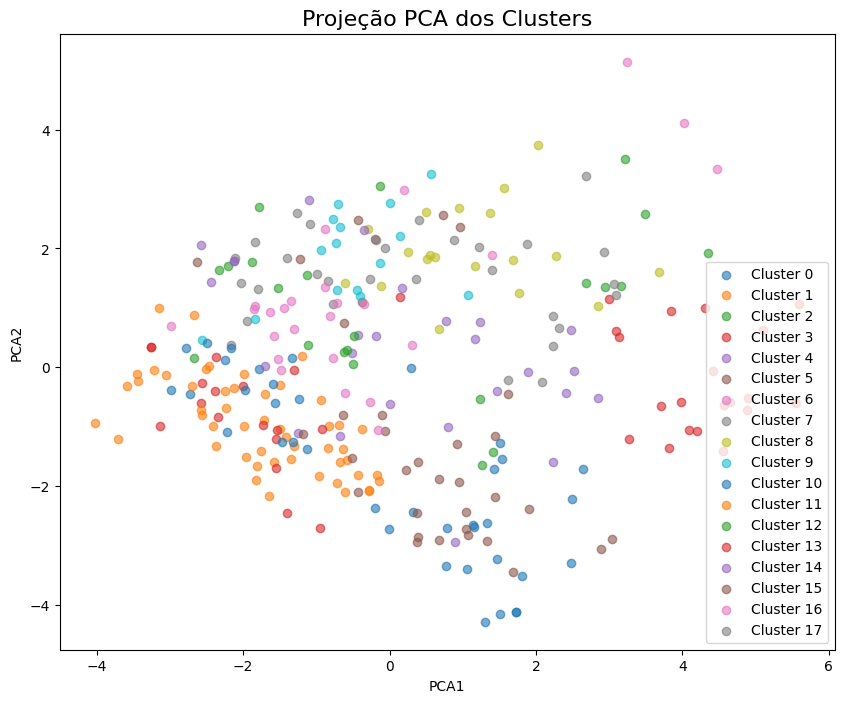

In [209]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduzir os embeddings para 2D usando PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

# Adicionar as componentes PCA ao DataFrame
data['PCA1'] = pca_components[:, 0]
data['PCA2'] = pca_components[:, 1]

# Plotar os clusters no gráfico 2D (PCA)
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    cluster_data = data[data['Cluster'] == i]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {i}', alpha=0.6)

plt.title("Projeção PCA dos Clusters", fontsize=16)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()


# 6: Preparação para o Treinamento

## Dividir os Dados em Treinamento e Validação

In [210]:
from sklearn.model_selection import train_test_split

# Dividir os dados em treinamento e validação
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Texto'],  # Texto
    data['Cluster'],  # Rótulos dos clusters
    test_size=0.2,  # 20% para validação
    random_state=42
)

# Verificar as primeiras linhas das divisões
print(f"Treinamento: {len(train_texts)} textos")
print(f"Validação: {len(val_texts)} textos")


Treinamento: 238 textos
Validação: 60 textos


## Tokenizar os Textos para Treinamento

In [211]:
from transformers import AutoTokenizer

# Carregar o tokenizer do BERTimbau
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

# Função para tokenizar os textos
def tokenize_function(batch):
    return tokenizer(batch['Texto'], padding="max_length", truncation=True, max_length=128)

# Tokenizar os textos de treino e validação
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

# Verificar se a tokenização foi bem-sucedida
print(train_encodings.keys())  # Exibir as chaves dos encodings


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


## Criar o Dataset para PyTorch

In [212]:
import torch

# Criar a classe para o Dataset
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Criar os datasets de treino e validação
train_dataset = TextDataset(train_encodings, train_labels.tolist())
val_dataset = TextDataset(val_encodings, val_labels.tolist())

# Verificar o tamanho do dataset
print(f"Tamanho do conjunto de treinamento: {len(train_dataset)}")
print(f"Tamanho do conjunto de validação: {len(val_dataset)}")

Tamanho do conjunto de treinamento: 238
Tamanho do conjunto de validação: 60


# 7: Treinamento do Modelo BERT

## Carregar o Modelo BERT para Classificação

In [213]:
from transformers import AutoModelForSequenceClassification

# Carregar o modelo BERT para classificação de textos
model = AutoModelForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",  # Modelo BERTimbau
    num_labels=len(data['Cluster'].unique())  # Número de clusters
)

# Mover o modelo para o dispositivo (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Verificar a arquitetura do modelo
print(model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Configurar os Argumentos de Treinamento

In [214]:
from transformers import TrainingArguments

# Configurar os parâmetros de treinamento
training_args = TrainingArguments(
    output_dir='./results',  # Diretório para salvar os resultados
    eval_strategy="epoch",  # Avaliar por época
    save_strategy="epoch",  # Salvar o modelo a cada época
    learning_rate=2e-5,  # Taxa de aprendizado
    per_device_train_batch_size=8,  # Tamanho do batch para treino
    per_device_eval_batch_size=8,  # Tamanho do batch para validação
    num_train_epochs=3,  # Número de épocas de treinamento
    weight_decay=0.01,  # Decaimento do peso
    logging_dir='./logs',  # Diretório de logs
    logging_steps=10,  # Número de steps para logar
)

# Verificar os parâmetros de treinamento
print(training_args)

TrainingArguments(
_n_gpu=2,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=epoch,
eval_use_gather_object

## Criar o Trainer

In [215]:
from transformers import Trainer

# Configurar o Trainer
trainer = Trainer(
    model=model,  # O modelo a ser treinado
    args=training_args,  # Argumentos de treinamento
    train_dataset=train_dataset,  # Dataset de treinamento
    eval_dataset=val_dataset,  # Dataset de validação
)

# Verificar se o trainer foi configurado corretamente
print(trainer)

## Treinar o Modelo 

In [216]:
# Treinar o modelo
trainer.train()

Epoch,Training Loss,Validation Loss
1,2.877600,2.858715
2,2.725800,2.781783
3,2.663900,2.751227


TrainOutput(global_step=45, training_loss=2.7672436396280924, metrics={'train_runtime': 56.416, 'train_samples_per_second': 12.656, 'train_steps_per_second': 0.798, 'total_flos': 187888281219072.0, 'train_loss': 2.7672436396280924, 'epoch': 3.0})

# 8: Avaliação do Modelo

## Avaliar o Modelo no Conjunto de Validação

In [217]:
# Avaliar o modelo no conjunto de validação
metrics = trainer.evaluate()

# Exibir as métricas de avaliação
print("Métricas de avaliação:", metrics)


Métricas de avaliação: {'eval_loss': 2.7512271404266357, 'eval_runtime': 1.1415, 'eval_samples_per_second': 52.563, 'eval_steps_per_second': 3.504, 'epoch': 3.0}


## Ajuste Fino

In [221]:
# Ajustar os parâmetros de treinamento, se necessário
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=7e-5,  # Ajuste a taxa de aprendizado se necessário
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,  # Aumente o número de épocas se necessário
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Recriar o trainer com os novos parâmetros
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Treinar novamente com os novos parâmetros
trainer.train()


Epoch,Training Loss,Validation Loss
1,2.576000,2.351098
2,1.833900,1.975498
3,1.463700,1.750612
4,0.996500,1.583042
5,0.810600,1.517852
6,0.679500,1.495846


TrainOutput(global_step=90, training_loss=1.4061810864342583, metrics={'train_runtime': 106.9356, 'train_samples_per_second': 13.354, 'train_steps_per_second': 0.842, 'total_flos': 375776562438144.0, 'train_loss': 1.4061810864342583, 'epoch': 6.0})

# 9: Predição de Novos Textos

## Preparar os Novos Textos para Predição

In [219]:
from sklearn.preprocessing import LabelEncoder

# Codificar os clusters como números
label_encoder = LabelEncoder()
data['Cluster_Label'] = label_encoder.fit_transform(data['Cluster'])

# Novos textos para previsão (substitua por textos reais)
new_texts = [
    "Inteligência Artificial está revolucionando a indústria.",
    "O Brasil tem uma grande biodiversidade na Amazônia.",
    "Tecnologias sustentáveis são essenciais para o futuro.",
    "A inovação no setor financeiro é impulsionada pela tecnologia."
]

# Tokenizar os novos textos
new_encodings = tokenizer(new_texts, padding=True, truncation=True, max_length=512, return_tensors="pt").to(model.device)

# Realizar as previsões
model.eval()  # Colocar o modelo em modo de avaliação
with torch.no_grad():
    outputs = model(**new_encodings)
    logits = outputs.logits
    predicted_classes = torch.argmax(logits, dim=1).cpu().numpy()

# Exibir as previsões dos clusters
predicted_clusters = [label_encoder.inverse_transform([cls])[0] for cls in predicted_classes]
for text, cluster in zip(new_texts, predicted_clusters):
    print(f"O texto: '{text}' foi classificado no cluster: {cluster}")


O texto: 'Inteligência Artificial está revolucionando a indústria.' foi classificado no cluster: 1
O texto: 'O Brasil tem uma grande biodiversidade na Amazônia.' foi classificado no cluster: 1
O texto: 'Tecnologias sustentáveis são essenciais para o futuro.' foi classificado no cluster: 9
O texto: 'A inovação no setor financeiro é impulsionada pela tecnologia.' foi classificado no cluster: 13


## Visualizar os Resultados das Previsões

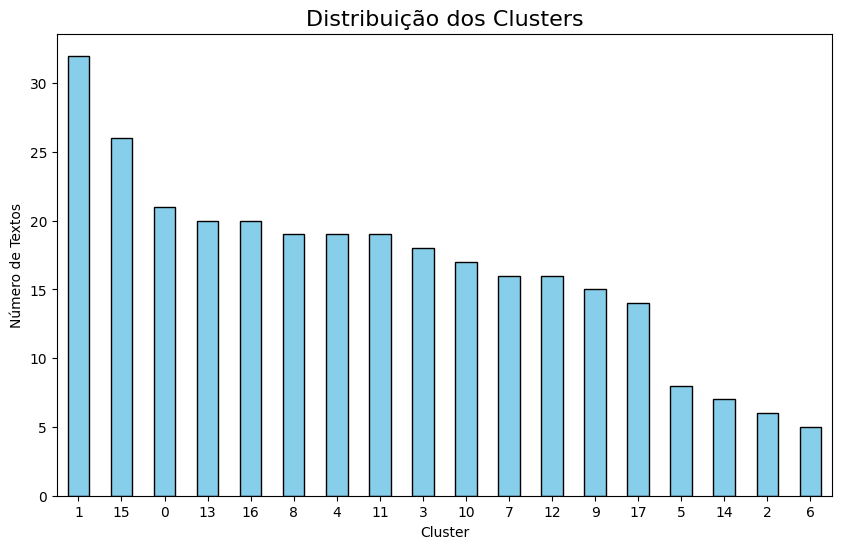

In [220]:
# Contagem de textos por cluster
cluster_counts = data['Cluster'].value_counts()

# Plotar a distribuição dos clusters
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribuição dos Clusters", fontsize=16)
plt.xlabel("Cluster")
plt.ylabel("Número de Textos")
plt.xticks(rotation=0)
plt.show()
